In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import plotly.graph_objects as go

# Part 1: Fetching Stock Data

In [ ]:
def fetch_stock_data(ticker_list, years=5):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years * 365)

    close_data_df = pd.DataFrame()
    high_data_df = pd.DataFrame()
    low_data_df = pd.DataFrame()

    for ticker in ticker_list:
        stock = yf.Ticker(ticker)

        hist_data = stock.history(period='1d', start=start_date, end=end_date)

        close_data = hist_data['Close'].rename(ticker)
        close_data_df = pd.merge(close_data_df, pd.DataFrame(close_data), left_index=True, right_index=True, how='outer')

        high_data = hist_data['High'].rename(ticker)
        high_data_df = pd.merge(high_data_df, pd.DataFrame(high_data), left_index=True, right_index=True, how='outer')

        low_data = hist_data['Low'].rename(ticker)
        low_data_df = pd.merge(low_data_df, pd.DataFrame(low_data), left_index=True, right_index=True, how='outer')

    return close_data_df, high_data_df, low_data_df

# Fetch the data
ticker_list = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'META', 'TSLA', 'NVDA', 'ADBE', 'NFLX', 'INTC']
years = 5

close, high, low = fetch_stock_data(ticker_list, years)

# Part 2: Compute the Highs and Lows in a Window

In [ ]:
def get_high_lows_lookback(high, low, lookback_days):
    lookback_high = high.shift(1).rolling(lookback_days).max()
    lookback_low = low.shift(1).rolling(lookback_days).min()

    return lookback_high, lookback_low

lookback_days = 50
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)

# Part 3: Compute Long and Short Signals

In [ ]:
def get_long_short(close, lookback_high, lookback_low):
    long_signal = (close-lookback_high > 0).astype('int')
    short_signal = -(close-lookback_low < 0).astype('int')
    long_short = short_signal + long_signal

    return long_short

signal = get_long_short(close, lookback_high, lookback_low)

# Part 4: Filter Signal

In [ ]:
def clear_signals(signals, window_size):
    clean_signals = [0]*window_size

    for signal_i, current_signal in enumerate(signals):
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        clean_signals.append(not has_past_signal and current_signal)

    clean_signals = clean_signals[window_size:]

    return pd.Series(np.array(clean_signals).astype(int), signals.index)

def filter_signals(signal, lookahead_days):

    long_signals = (signal > 0 ).astype('int')
    short_signals = -(signal < 0 ).astype('int')

    long_signals = long_signals.apply(lambda s: clear_signals(s, window_size = lookahead_days))
    short_signals = short_signals.apply(lambda s: clear_signals(s, window_size = lookahead_days))

    filtered_signal = long_signals + short_signals

    return filtered_signal

signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)

# Part 5: Lookahead Close Prices & Price Returns

In [ ]:
def get_lookahead_prices(close, lookahead_days):
    lookahead_prices = close.shift(-lookahead_days)

    return lookahead_prices

lookahead_5 = get_lookahead_prices(close, 5)
lookahead_10 = get_lookahead_prices(close, 10)
lookahead_20 = get_lookahead_prices(close, 20)

In [ ]:
def get_return_lookahead(close, lookahead_prices):
    lookahead_returns = np.log(lookahead_prices/close)

    return lookahead_returns

price_return_5 = get_return_lookahead(close, lookahead_5)
price_return_10 = get_return_lookahead(close, lookahead_10)
price_return_20 = get_return_lookahead(close, lookahead_20)

# Part 6: Compute the Signal Return

In [ ]:
def get_signal_return(signal, lookahead_returns):
    signal_return = signal * lookahead_returns

    return signal_return

signal_return_5 = get_signal_return(signal_5, price_return_5)
signal_return_10 = get_signal_return(signal_10, price_return_10)
signal_return_20 = get_signal_return(signal_20, price_return_20)

# Part 7: Analysis and Visualization of Signal Returns


In [ ]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import warnings

dataframes = [signal_return_5, signal_return_10, signal_return_20]
colors = ['blue', 'green', 'red']
labels = ['signal_return_5', 'signal_return_10', 'signal_return_20']

## A. Plotting histograms of Signal Returns

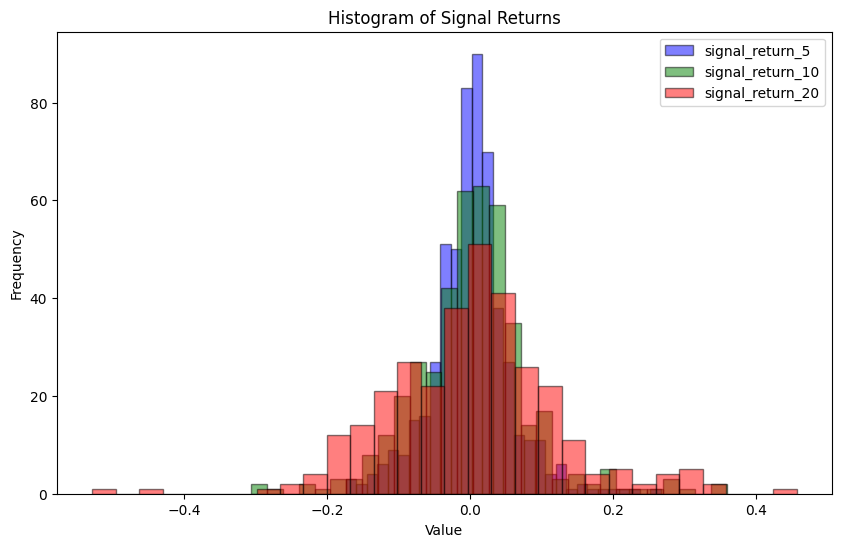

In [ ]:
plt.figure(figsize=(10, 6))

for df, color, label in zip(dataframes, colors, labels):
    # Filter out NaN and zero values and flatten the data
    filtered_data = df.values[~pd.isna(df.values)]
    filtered_data = filtered_data[filtered_data != 0.0]

    # Plot the histogram
    plt.hist(filtered_data, bins=30, edgecolor='black', alpha=0.5, color=color, label=label)

plt.title('Histogram of Signal Returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## B. Test for Normality using the Shapiro-Wilk Test

In [ ]:
means = []

for df, label in zip(dataframes, labels):
    # Filter out NaN and zero values and flatten the data
    filtered_data = df.values[~pd.isna(df.values)]
    filtered_data = filtered_data[filtered_data != 0.0]

    # Calculate the mean
    mean_val = filtered_data.mean()
    means.append(mean_val)

    # Shapiro-Wilk Test
    stat, p = shapiro(filtered_data)
    alpha = 0.05
    if p > alpha:
        print(f"{label}: Looks Gaussian (fail to reject H0). p-value = {p:.5f}")
    else:
        print(f"{label}: Does not look Gaussian (reject H0). p-value = {p:.5f}")

print("\nMeans of the distributions:")
for label, mean in zip(labels, means):
    print(f"{label}: {mean:.5f}")

signal_return_5: Does not look Gaussian (reject H0). p-value = 0.00000
signal_return_10: Does not look Gaussian (reject H0). p-value = 0.00000
signal_return_20: Does not look Gaussian (reject H0). p-value = 0.00002

Means of the distributions:
signal_return_5: 0.00195
signal_return_10: 0.00262
signal_return_20: 0.00315


## C. Comparing the Signal Returns to a Normal Distribution

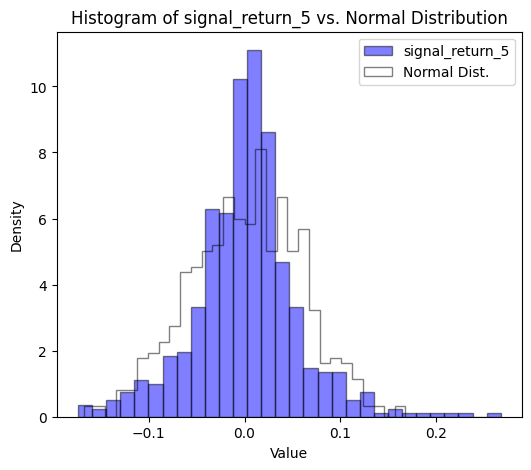

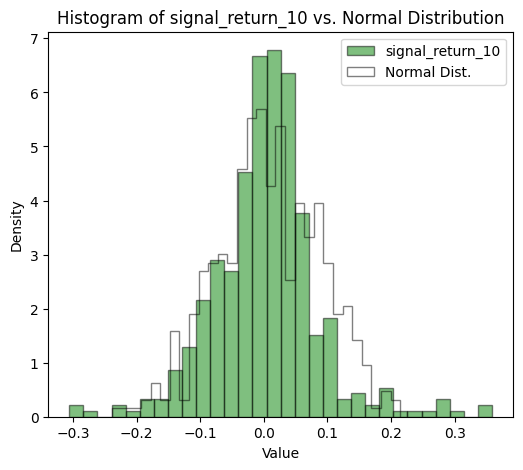

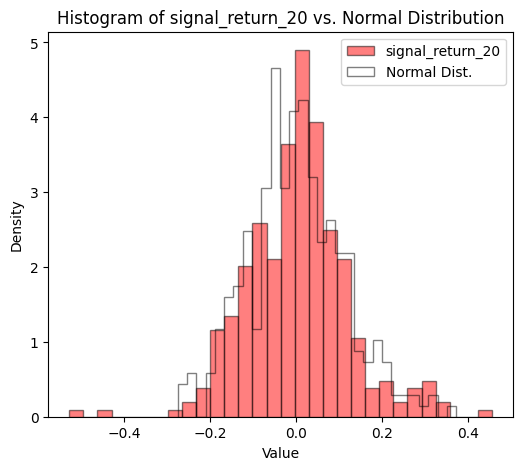

In [ ]:
for df, color, label in zip(dataframes, colors, labels):
    # Filter out NaN and zero values and flatten the data
    filtered_data = df.values[~pd.isna(df.values)]
    filtered_data = filtered_data[filtered_data != 0.0]

    # Parameters for normal distribution
    mean_val = filtered_data.mean()
    std_dev = filtered_data.std()

    # Generate random samples from a normal distribution with the same mean and std_dev
    normal_samples = np.random.normal(mean_val, std_dev, size=len(filtered_data))

    # Plot histograms
    plt.figure(figsize=(6, 5))
    plt.hist(filtered_data, bins=30, edgecolor='black', alpha=0.5, color=color, label=label, density=True)
    plt.hist(normal_samples, bins=30, edgecolor='black', alpha=0.5, color='grey', label='Normal Dist.', density=True, histtype='step')
    plt.title(f'Histogram of {label} vs. Normal Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print('\n')

## D. Kolmogorov-Smirnov Test to assess the goodness of fit

In [ ]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

In [ ]:
import pandas as pd
import warnings
from scipy.stats import kstest

warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_kstest(long_short_signal_returns):
    ks_values = pd.Series(dtype='float64')
    p_values = pd.Series(dtype='float64')

    for ticker, signals in long_short_signal_returns.groupby('ticker')['signal_return']:
        mean = signals.mean()
        std = signals.std(ddof=0)
        standardized_signals = (signals - mean) / std
        ks_value, p_value = kstest(standardized_signals, 'norm')
        ks_values[ticker] = ks_value
        p_values[ticker] = p_value

    return ks_values, p_values

# Calculate KS test values for all three dataframes
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)

# Compile results into a DataFrame
results = pd.DataFrame({
    'ticker': ks_values_5.index,
    'ks_value_5': ks_values_5.values,
    'p_value_5': p_values_5.values,
    'ks_value_10': ks_values_10.values,
    'p_value_10': p_values_10.values,
    'ks_value_20': ks_values_20.values,
    'p_value_20': p_values_20.values,
})

# Use style.bar to display the bars for easier visual comparison
results.style.bar(subset=['ks_value_5', 'p_value_5', 'ks_value_10', 'p_value_10', 'ks_value_20', 'p_value_20'], align='zero', color=['#d65f5f', '#000000'])

,ticker,ks_value_5,p_value_5,ks_value_10,p_value_10,ks_value_20,p_value_20
0,AAPL,0.112281,0.349863,0.138618,0.310424,0.084568,0.956395
1,ADBE,0.066003,0.954290,0.167865,0.157879,0.065764,0.996987
2,AMZN,0.109672,0.598782,0.093366,0.892654,0.121015,0.744719
3,GOOGL,0.135926,0.266832,0.103787,0.743213,0.197013,0.157280
4,INTC,0.080248,0.871630,0.089608,0.876640,0.131356,0.651176
5,META,0.056786,0.989012,0.090317,0.843324,0.105450,0.819459
6,MSFT,0.111432,0.395617,0.129261,0.392218,0.123694,0.613795
7,NFLX,0.100737,0.689090,0.152270,0.282107,0.084259,0.971325
8,NVDA,0.087753,0.720651,0.107234,0.626645,0.076785,0.978935
9,TSLA,0.075150,0.880271,0.129021,0.479076,0.113354,0.794743
